# Домашнее задание №10.
# Машинный перевод. Модель seq2seq и механизм внимания.

## Задание

Разобраться с моделькой перевода как она устроена запустить для перевода с русского на английский (при желании можно взять другие пары языков).

In [1]:
#!g2.mig
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from pathlib import Path

## Загрузка данных

In [2]:
#!g2.mig
# Скачиваем датасет
!wget http://www.manythings.org/anki/rus-eng.zip

--2023-02-20 05:33:06--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15011848 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

     0K .......... .......... .......... .......... ..........  0%  138K 1m46s
    50K .......... .......... .......... .......... ..........  0%  277K 79s
   100K .......... .......... .......... .......... ..........  1%  324M 52s
   150K .......... .......... .......... .......... ..........  1%  152M 39s
   200K .......... .......... .......... .......... ..........  1%  277K 42s
   250K .......... .......... .......... .......... ..........  2%  263M 35s
   300K .......... .......... .......... .......... ..........  2%  337M 30s
   350K .......... .......... .......... .......... ..........  2%  279M 26s
   400K .......... .......... .......... ....

In [3]:
#!g2.mig
# Создаем папку и извлекаем туда файлы из архива
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
#!g2.mig
# Загружаем файл
path_to_file = "/home/jupyter/work/resources/10_Машинный_перевод/rus-eng/rus.txt"

In [5]:
#!g2.mig
# Просмотр файла
f = open(path_to_file)
for line in f:
    print(line)
    break

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)



## Подготовка данных

### Препроцессинг слова

In [6]:
#!g2.mig
# Функция препроцессинга
def preprocess_sentence(w):
  #переводим предложение к нижнему регистру и удалем начальные и конечные пробелы
    w = w.lower().strip()

  # Отделяем пробелом слово и следующую за ним пунктуацию
  # Пример: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

  # Все, кроме букв и знаков пунктуации, заменяем пробелом
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
  
  # Удаляем лишние пробелы в начале и конце
    w = w.strip()

  # Создаем начало и конец последовательности
  # Теперь модель знает, где начинать и заканчивать предсказания
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
#!g2.mig
# Пример работы препроцессинга
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

### Создаем датасет

In [8]:
#!g2.mig
# 1. Убираем акценты
# 2. Очищаем предложения
# 3. Возвращаем пары слов: [ENG, RUS]
def create_dataset(path, num_examples):
  # Считываем строки файла
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  # Каждую строку разделяем на пробелы, берем первые 2 слова, препроцессим их и возвращаем пару
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [9]:
#!g2.mig
# Пример работы
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [10]:
#!g2.mig
# Количество данных в датасете
len(en), len(ru)

(451436, 451436)

### Загрузчик датасета

In [11]:
#!g2.mig
def tokenize(lang):
      #токенизируем текст, отфильтвовываем пробелы
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
      #обновляем внутренний словарь на основе lang
    lang_tokenizer.fit_on_texts(lang)
      #преобразуем каждый элемент из lang в последовательность чисел
    tensor = lang_tokenizer.texts_to_sequences(lang)
      #преобразуем тензор в матрицу (кол-во тензоров * max-длина), 
      #при этом короткие последовательности заполняем нулями сзади, а длинные -- обрезаем сзади
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

## Создание датасета

In [12]:
#!g2.mig
def load_dataset(path, num_examples=None):
      # создаем очищенные анг (выходные), русские (входные) пары
    targ_lang, inp_lang = create_dataset(path, num_examples)
    #применяем токенизацию к каждому элементы из пары
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [13]:
#!g2.mig
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

input_tensor, target_tensor

(array([[   1, 5663,   24, ...,    0,    0,    0],
        [   1,  198,    3, ...,    0,    0,    0],
        [   1,  301,    3, ...,    0,    0,    0],
        ...,
        [   1,   33,  234, ...,    0,    0,    0],
        [   1,   10,  298, ...,    0,    0,    0],
        [   1,   27,   65, ...,    0,    0,    0]], dtype=int32),
 array([[ 1, 27,  3, ...,  0,  0,  0],
        [ 1, 27,  3, ...,  0,  0,  0],
        [ 1, 27,  3, ...,  0,  0,  0],
        ...,
        [ 1, 15,  7, ...,  0,  0,  0],
        [ 1, 15,  7, ...,  0,  0,  0],
        [ 1, 15,  7, ...,  0,  0,  0]], dtype=int32))

In [14]:
#!g2.mig
# Вычисляем максимальную длину тензоров
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(11, 15)

In [15]:
#!g2.mig
# Создаем тренировочные и валидационные датасеты
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Размеры датасетов
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [16]:
#!g2.mig
input_tensor_train, target_tensor_train

(array([[    1,     4,     7, ...,     0,     0,     0],
        [    1,     6,     9, ...,     0,     0,     0],
        [    1,     6,   203, ...,     0,     0,     0],
        ...,
        [    1,    35,     7, ...,     0,     0,     0],
        [    1, 15048,   397, ...,     0,     0,     0],
        [    1,  1033,    20, ...,     0,     0,     0]], dtype=int32),
 array([[  1,   4, 114, ...,   0,   0,   0],
        [  1,   5, 392, ...,   0,   0,   0],
        [  1,   5, 137, ...,   0,   0,   0],
        ...,
        [  1, 316,  69, ...,   0,   0,   0],
        [  1, 478,  54, ...,   0,   0,   0],
        [  1, 165,  34, ...,   0,   0,   0]], dtype=int32))

In [17]:
#!g2.mig
# Функция получения из токена текста (выводим токен и его индекс)
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
#!g2.mig
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> я
7 ----> не
1924 ----> занимаюсь
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
114 ----> am
31 ----> not
845 ----> studying
3 ----> .
2 ----> <end>


In [19]:
#!g2.mig
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
# Количество эпох
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
# Из каждого элемента (input_tensor_train, target_tensor_train) создает тензор
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# Разбиваем датасет на батчи (списки по 64), удаляя последний неполный батч
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2023-02-20 05:33:38.661995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 05:33:41.177767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0


In [20]:
#!g2.mig
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)
example_input_batch[0], example_target_batch[0]

(64, 15) (64, 11)


(<tf.Tensor: shape=(15,), dtype=int32, numpy=
 array([  1, 419,   9,  17,   4, 517,   3,   2,   0,   0,   0,   0,   0,
          0,   0], dtype=int32)>,
 <tf.Tensor: shape=(11,), dtype=int32, numpy=array([  1,  15,  35,   4, 135,   3,   2,   0,   0,   0,   0], dtype=int32)>)

## Построение модели машинного перевода

### Encoder

In [21]:
#!g2.mig
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
    #создаем тензор из нулей размера (батч, кол-во ячеек)
        return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
#!g2.mig
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализитеруем начальное скрытое состояние (из нулей)
sample_hidden = encoder.initialize_hidden_state()
# применяем энкодер к входному батчу и скрытому состоянию
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Форма выхода энкодера: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

2023-02-20 05:33:45.868764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


Encoder Hidden state shape: (batch size, units) (64, 1024)


In [23]:
#!g2.mig
sample_hidden

<tf.Tensor: shape=(64, 1024), dtype=float32, numpy=
array([[ 0.02330193,  0.01872611, -0.00576977, ..., -0.01749688,
        -0.02627492, -0.00945185],
       [ 0.02349954,  0.01863672, -0.00549863, ..., -0.01758788,
        -0.02637304, -0.00938264],
       [ 0.02361627,  0.01884528, -0.00534972, ..., -0.01749588,
        -0.02672212, -0.00948581],
       ...,
       [ 0.02353191,  0.01881711, -0.00512481, ..., -0.01756242,
        -0.02684424, -0.0095759 ],
       [ 0.02355534,  0.01885203, -0.00521339, ..., -0.01759139,
        -0.02679635, -0.00949376],
       [ 0.02348568,  0.01865501, -0.00551217, ..., -0.01749637,
        -0.02636423, -0.00953596]], dtype=float32)>

### Decoder

In [24]:
#!g2.mig
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):
        # x shape после прохождения через эмбеддинг == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # отправляем в GRU входные данные и скрытое состояние (от энкодера)
        #выход GRU (batch_size, timesteps, units)
        #размер возвращаемого внутреннего состояния (batch_size, units)
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # x shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [25]:
#!g2.mig
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
# Применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходу энкодера
decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)
decoder_sample_x.shape, decoder_sample_h.shape

2023-02-20 05:33:51.128241: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(TensorShape([64, 7335]), TensorShape([64, 1024]))

In [26]:
#!g2.mig
decoder_sample_x

<tf.Tensor: shape=(64, 7335), dtype=float32, numpy=
array([[ 0.00068364, -0.00066774,  0.0022516 , ...,  0.00801814,
         0.00340847, -0.00804379],
       [ 0.00073537, -0.0006414 ,  0.00229872, ...,  0.00805619,
         0.00346467, -0.00795238],
       [ 0.00078047, -0.00060194,  0.00228008, ...,  0.00805415,
         0.00352017, -0.00791376],
       ...,
       [ 0.00077555, -0.00059668,  0.00229293, ...,  0.00810161,
         0.00353668, -0.0078459 ],
       [ 0.00078429, -0.00058722,  0.00228078, ...,  0.00807798,
         0.00353996, -0.00785472],
       [ 0.00070706, -0.00062992,  0.00224415, ...,  0.00800894,
         0.00348977, -0.00798003]], dtype=float32)>

### Компиляция модели

In [27]:
#!g2.mig
# Оптимизатор
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Функция потерь
def loss_function(real, pred):
      #делаем инверсию значений сравнения каждого из real с нулем (возвращается true или false)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
      # Применяем функцию ошибок к реальным данным и предсказанным
    loss_ = loss_object(real, pred)
      # Приводим тензор mask к новому типу loss_.dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
      # Умножаем loss_ на mask
    loss_ *= mask
      # Возвращаем среднее значениe всех элементов
    return tf.reduce_mean(loss_)

### Сheckpoint

In [28]:
#!g2.mig
checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Обучение модели

In [29]:
#!g2.mig
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
  # Перечисляем операции для автоматического дифференцирования
    with tf.GradientTape() as tape:
        # Получаем выход encoder
        enc_hidden = encoder(inp, enc_hidden)
        # Помещаем его в скрытое состояние decoder
        dec_hidden = enc_hidden
        # Формируем вход декодера:
                 # Берем список длины батч из индексов тега <start> (1)
                 # Приписываем списку размерность 1 сзади (батч, 1)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # Помещаем enc_output в decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
          # Считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
          # Используем teacher forcing (приписываем списку размерность 1 сзади)
          # Посылаем dec_input на вход декордера 
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    # Переменные
    variables = encoder.trainable_variables + decoder.trainable_variables
    # Вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    # Оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [30]:
#!g2.mig
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

  # Инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # Делаем шаг обучения. находим оштбку за этоху
        batch_loss = train_step(inp, targ, enc_hidden)
        # Считаем ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
  # Сохраняем контрольные точки каждые 2 эпохи
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2023-02-20 05:34:00.173097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Batch 0 Loss 4.6273
Epoch 1 Batch 100 Loss 2.0475
Epoch 1 Batch 200 Loss 1.8684
Epoch 1 Batch 300 Loss 1.5631
Epoch 1 Batch 400 Loss 1.4717
Epoch 1 Batch 500 Loss 1.4235
Epoch 1 Batch 600 Loss 1.2639
Epoch 1 Batch 700 Loss 1.2760
Epoch 1 Batch 800 Loss 1.2481
Epoch 1 Batch 900 Loss 1.0421
Epoch 1 Batch 1000 Loss 1.0551
Epoch 1 Batch 1100 Loss 0.9110
Epoch 1 Batch 1200 Loss 0.8704
Epoch 1 Loss 1.3991
Time taken for 1 epoch 77.67933869361877 sec

Epoch 2 Batch 0 Loss 0.8593
Epoch 2 Batch 100 Loss 0.8048
Epoch 2 Batch 200 Loss 0.8494
Epoch 2 Batch 300 Loss 0.7857
Epoch 2 Batch 400 Loss 0.8179
Epoch 2 Batch 500 Loss 0.6948
Epoch 2 Batch 600 Loss 0.7596
Epoch 2 Batch 700 Loss 0.6758
Epoch 2 Batch 800 Loss 0.7247
Epoch 2 Batch 900 Loss 0.5929
Epoch 2 Batch 1000 Loss 0.5928
Epoch 2 Batch 1100 Loss 0.5978
Epoch 2 Batch 1200 Loss 0.5692
Epoch 2 Loss 0.6951
Time taken for 1 epoch 70.99302291870117 sec

Epoch 3 Batch 0 Loss 0.4453
Epoch 3 Batch 100 Loss 0.4176
Epoch 3 Batch 200 Loss 0.434

### Перевод

* Функция оценки аналогична циклу обучения, за исключением того, что здесь мы не используем teacher forcing. Входным сигналом для декодера на каждом временном шаге являются его предыдущие предсказания вместе со скрытым состоянием и выходным сигналом энсодера.
* Предсказания модели прекращаются, когда модель предскажет end token.
* Сохраняем веса внимания для каждого временного шага.

Примечание: Выходной сигнал энкодера вычисляется только один раз для одного входа.

In [31]:
#!g2.mig
def evaluate(sentence):
  # Препоцессим предложение
    sentence = preprocess_sentence(sentence)
      # Разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
      # Добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=max_length_inp,
                                                             padding='post')
      # Преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
      # Инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
      # Подаем inputs и hidden в encoder
    enc_hidden = encoder(inputs, hidden)

      # Инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
      # Вход декодера -- список [индекс start] размера(1,1)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
            # Получаем выход декодера
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

   # Заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

    # Предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [32]:
#!g2.mig
# Функция перевода
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [33]:
#!g2.mig
# Загружаем последний checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
#!g2.mig
translate('Хорошая погода')

Input: <start> хорошая погода <end>
Predicted translation: this is a good cold . <end> 


In [35]:
#!g2.mig
translate('Я иду в школу')

Input: <start> я иду в школу <end>
Predicted translation: i walk to school . <end> 


In [36]:
#!g2.mig
translate('Мама приготовила вкусный обед для нашей большой семьи')

Input: <start> мама приготовила вкусный обед для нашей большой семьи <end>
Predicted translation: my dog works quickly . <end> 


In [37]:
#!g2.mig
translate(u'Мне здесь нравится, но я очень скучаю по дому. Там остались мама и папа.')

Input: <start> мне здесь нравится , но я очень скучаю по дому . там остались мама и папа . <end>
Predicted translation: i get your point . <end> 


**Вывод:** на длинных предложениях перевод хуже, что может быть связано с отсутствием учета контекста.

## Построение модели машинного перевода с вниманием

### Encoder

In [38]:
#!g2.mig
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [39]:
#!g2.mig
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Инициализируем начальное скрытое состояние из нулей
sample_hidden = encoder.initialize_hidden_state()
# Получаем выход энкодера и последнее скрытое состояние
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


### Attention

In [40]:
#!g2.mig
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # Query hidden state shape == (batch_size, hidden size)
        # Values shape == (batch_size, max_len, hidden size)

        # Query_with_time_axis shape == (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # Score shape == (batch_size, max_length, 1)
        # We get 1 at the last axis because we are applying score to self.V
        # The shape of the tensor before applying self.V is (batch_size, max_length, units)
        
        # Применяем к векторам скрытого состояния и выходов энкодера полносвязный слой (выход (batch_size, 1, units) и (batch_size, max_length, units))
        # Складываем полученные векторы, применяем к сумму тангенс выход (batch_size, max_length, units)
        # Проводим результат через dense слой выход (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # Attention_weights shape == (batch_size, max_length, 1)
        # Получаем вероятностное распределение
        attention_weights = tf.nn.softmax(score, axis=1)

        # Context_vector shape after sum == (batch_size, hidden_size)
        # Умножаем веса внимания умножаем на векторы значенй выход (batch_size, max_len, hidden size)
        context_vector = attention_weights * values
        # Находим вдоль столбцов (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [41]:
#!g2.mig
# Создаем слой внимания
attention_layer = BahdanauAttention(10)
# Передаем выход энкодера и его скрытое состояние
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [42]:
#!g2.mig
# Вектор контекста
attention_result

<tf.Tensor: shape=(64, 1024), dtype=float32, numpy=
array([[-0.00095868,  0.0037712 ,  0.00030837, ..., -0.01048669,
        -0.00051526, -0.00482616],
       [-0.00041407,  0.00849887, -0.00266971, ..., -0.01305983,
        -0.00457067, -0.00124785],
       [-0.00046182,  0.00472675, -0.00431802, ..., -0.01144347,
        -0.00294155, -0.00372045],
       ...,
       [-0.00211136,  0.00707744, -0.00192837, ..., -0.01122575,
         0.00064262, -0.00166406],
       [ 0.0014904 ,  0.00625178, -0.00196154, ..., -0.01102399,
        -0.00055026, -0.00374676],
       [ 0.00312438,  0.00319219,  0.00135375, ..., -0.00911092,
        -0.00023989, -0.00515693]], dtype=float32)>

In [43]:
#!g2.mig
# Веса внимания
attention_weights

<tf.Tensor: shape=(64, 15, 1), dtype=float32, numpy=
array([[[0.06607861],
        [0.06707446],
        [0.0673137 ],
        [0.06809489],
        [0.06647553],
        [0.06607323],
        [0.06739506],
        [0.06709792],
        [0.06706234],
        [0.06682284],
        [0.06654294],
        [0.06628067],
        [0.06605876],
        [0.0658818 ],
        [0.06574725]],

       [[0.06624756],
        [0.06704309],
        [0.06631398],
        [0.06729461],
        [0.06651884],
        [0.06794392],
        [0.06749769],
        [0.06731556],
        [0.06697959],
        [0.06665399],
        [0.06637914],
        [0.06616081],
        [0.06599401],
        [0.06587204],
        [0.06578515]],

       [[0.06591919],
        [0.06730799],
        [0.0671017 ],
        [0.06818235],
        [0.06874469],
        [0.06782924],
        [0.06738321],
        [0.0668905 ],
        [0.06647083],
        [0.06613895],
        [0.06588686],
        [0.06569983],
        [0.0655652 

### Decoder

In [44]:
#!g2.mig
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # Используем слой внимания
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # Enc_output shape == (batch_size, max_length, hidden_size)
        # Получаем выходы слоя внимания (из скрытого состояния и выхода энкодера)
        # Context_vector shape == (batch_size, hidden_size)
        # Attention_weights shape == (batch_size, max_len, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        # Соединяем выход эмбеддинга с вектором контекста и подаем навход RNN
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # (batch_size, 1, hidden_size) --> output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # Output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [45]:
#!g2.mig
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
# Применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходам энкодера
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (64, 7335)


In [46]:
#!g2.mig
sample_decoder_output

<tf.Tensor: shape=(64, 7335), dtype=float32, numpy=
array([[-0.00431752,  0.00183496, -0.002612  , ..., -0.00067051,
        -0.00290763,  0.00045797],
       [-0.004483  ,  0.00149953, -0.00244687, ..., -0.00018436,
        -0.00315358,  0.00072791],
       [-0.00474681,  0.00121364, -0.00279857, ..., -0.00051203,
        -0.00280373,  0.00027528],
       ...,
       [-0.00436075,  0.00140361, -0.00272169, ..., -0.0004665 ,
        -0.00391093,  0.00045581],
       [-0.00442866,  0.00139743, -0.00292976, ..., -0.00032783,
        -0.00259674,  0.00030078],
       [-0.00407641,  0.00242041, -0.00234986, ..., -0.00041125,
        -0.00371192,  0.00056452]], dtype=float32)>

### Сheckpoint

In [47]:
#!g2.mig
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Обучение модели

In [48]:
#!g2.mig
@tf.function
def train_step_att(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        # Получаем выходы encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        # Помещаем выходное скрытое состояние энкодера в скрытое состояние decoder
        dec_hidden = enc_hidden
        # Формируем вход декодера:
             # Берем список длины батч из индексов тега <start>
             # Приписываем списку размерность 1 сзади
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # Помещаем enc_output, dec_input, dec_hidden в decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            # Считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
            # Используем teacher forcing (приписываем списку размерность 1 сзади)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    # Переменные
    variables = encoder.trainable_variables + decoder.trainable_variables
    # Вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    # Оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [49]:
#!g2.mig
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    # Инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # Делаем шаг обучения
        batch_loss = train_step_att(inp, targ, enc_hidden)
        # Считаем ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # Сохраняем модель каждые 2 эпохи
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5261
Epoch 1 Batch 100 Loss 1.9116
Epoch 1 Batch 200 Loss 1.5853
Epoch 1 Batch 300 Loss 1.5470
Epoch 1 Batch 400 Loss 1.4870
Epoch 1 Batch 500 Loss 1.3588
Epoch 1 Batch 600 Loss 1.2534
Epoch 1 Batch 700 Loss 1.1858
Epoch 1 Batch 800 Loss 1.2579
Epoch 1 Batch 900 Loss 1.1737
Epoch 1 Batch 1000 Loss 1.0625
Epoch 1 Batch 1100 Loss 1.0047
Epoch 1 Batch 1200 Loss 1.0235
Epoch 1 Loss 1.3939
Time taken for 1 epoch 117.6727466583252 sec

Epoch 2 Batch 0 Loss 0.9361
Epoch 2 Batch 100 Loss 0.9212
Epoch 2 Batch 200 Loss 0.9018
Epoch 2 Batch 300 Loss 0.8291
Epoch 2 Batch 400 Loss 0.8947
Epoch 2 Batch 500 Loss 0.7480
Epoch 2 Batch 600 Loss 0.7704
Epoch 2 Batch 700 Loss 0.7566
Epoch 2 Batch 800 Loss 0.7194
Epoch 2 Batch 900 Loss 0.7015
Epoch 2 Batch 1000 Loss 0.6712
Epoch 2 Batch 1100 Loss 0.6802
Epoch 2 Batch 1200 Loss 0.6101
Epoch 2 Loss 0.7601
Time taken for 1 epoch 111.00780248641968 sec

Epoch 3 Batch 0 Loss 0.5206
Epoch 3 Batch 100 Loss 0.4091
Epoch 3 Batch 200 Loss 0.42

### Перевод

In [50]:
#!g2.mig
def evaluate_att(sentence):
    # Строим матрицу внимания из нулей размера (макс длина таргета, макс длина входа)  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    # Препоцессим предложение
    sentence = preprocess_sentence(sentence)
    # Разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    # Добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    # Преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # Инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
    # Подаем inputs и hidden в encoder
    enc_out, enc_hidden = encoder(inputs, hidden)

    # Инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
    # Вход декодера -- список [индекс start] размера(1,1)  
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        # Получаем выход декодера
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # Сохраняем веса внимания, чтобы позже визуализировать
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        # Заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # Предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [51]:
#!g2.mig
# Визуализация весов внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [52]:
#!g2.mig
def translate_att(sentence):
    result, sentence, attention_plot = evaluate_att(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [53]:
#!g2.mig
# Восстанавливаем последнюю контрольную точку
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> хорошая погода <end>
Predicted translation: it's good weekend . <end> 


<ipython-input-51-5f13abce0f10>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-51-5f13abce0f10>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


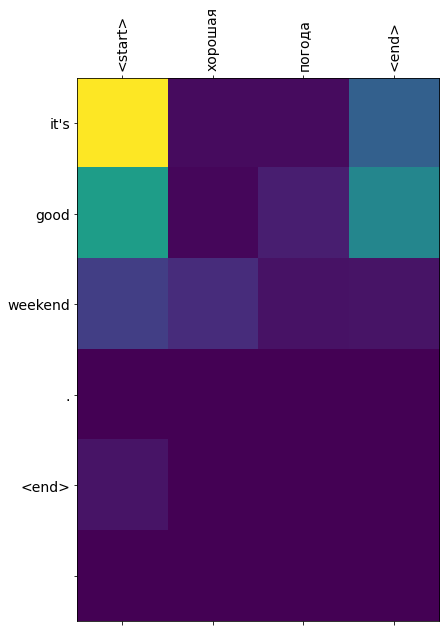

In [54]:
#!g2.mig
translate_att('Хорошая погода')

2023-02-20 16:30:25.135736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 16:30:27.736502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0
2023-02-20 16:30:47.970425: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-02-20 16:30:51.952032: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Input: <start> я иду в школу <end>
Predicted translation: i'm going to school . <end> 


<ipython-input-51-5f13abce0f10>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-51-5f13abce0f10>:10: UserWarning: FixedFormatter should only be used together with FixedLocator


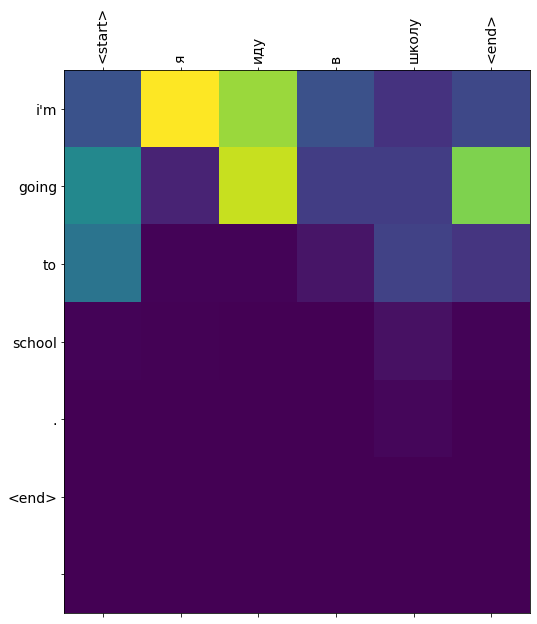

In [56]:
#!g2.mig
translate_att('Я иду в школу')

Input: <start> мама приготовила вкусный обед для нашей большой семьи <end>
Predicted translation: my we've got fun of time . <end> 


<ipython-input-51-5f13abce0f10>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-51-5f13abce0f10>:10: UserWarning: FixedFormatter should only be used together with FixedLocator


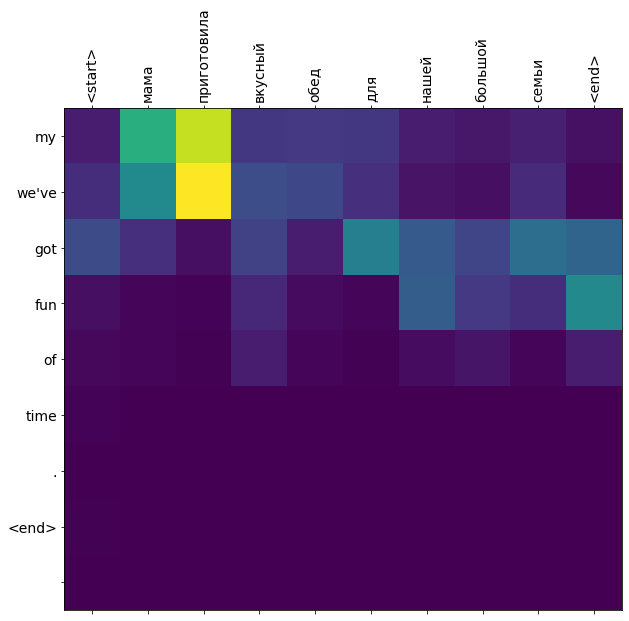

In [57]:
#!g2.mig
translate_att('Мама приготовила вкусный обед для нашей большой семьи')

Input: <start> мне здесь нравится , но я очень скучаю по дому . там остались мама и папа . <end>
Predicted translation: i'm not really safe there , but big of us very 


<ipython-input-51-5f13abce0f10>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-51-5f13abce0f10>:10: UserWarning: FixedFormatter should only be used together with FixedLocator


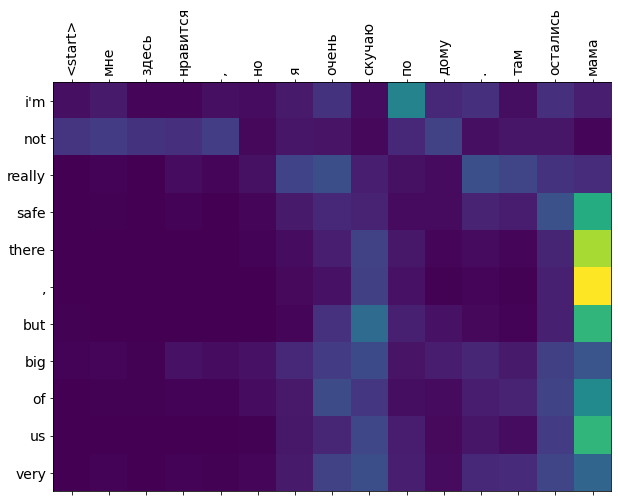

In [58]:
#!g2.mig
translate_att(u'Мне здесь нравится, но я очень скучаю по дому. Там остались мама и папа.')

### Вывод:

Перевод модели со вниманием также имеет неточности.